In [1]:
import pandas as pd

import numpy as np
from rdkit import Chem
import torch
from torch.utils.data import Dataset

In [2]:
from pom_models.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# MCF imports
from molecule_validation import is_odorant, score_molecule


############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:

def calculate_score(mol, is_vanilla):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol)[0] + score_molecule(mol).all() + is_vanilla)/3

def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return int(is_odorant(mol)[0]) + score_molecule(mol).all()

def hard_filter(mol):
    return int(int(is_odorant(mol)[0]) * score_molecule(mol).all())

### Define dataset

In [5]:
class OpenPOMDataset(Dataset):
    def __init__(self, openpom_file="openpomdata.csv", train=True, split_seed=142857, ratio=0.9):
        df = pd.read_csv(openpom_file).drop("descriptors",axis=1)
        df =  df[df['odorless'] == False]
        df = df[df["nonStereoSMILES"].apply(self.explicit_H_filter)].copy()  
        df = df.reset_index(drop=True)

        # Scent corrolation 
        scent_matrix = df[df.keys()[1:]].to_numpy()

        vanilla_idx = list(df.keys()[1:]).index("vanilla")  

        # compute Pearson correlation between vanilla and every other scent
        vanilla_col = scent_matrix[:, vanilla_idx]
        corrs = np.array([np.corrcoef(vanilla_col, scent_matrix[:, i])[0,1] for i in range(138)])
        vanilla_corr_vec = np.nan_to_num(corrs)  # shape: (138,), with NaNs replaced by 0


        scent_cols = df.columns[1:]
        df["reward"]= df[scent_cols].apply(lambda x: self.cosine_similarity(x, vanilla_corr_vec), axis=1)

        # Normalize to [0.1, 1.0] range (or any positive range you like)
        min_r = df["reward"].min()
        max_r = df["reward"].max()

        # Avoid zero reward
        scaled_rewards = 0.1 + 0.9 * (df["reward"] - min_r) / (max_r - min_r)
        df["shift_reward"] = scaled_rewards
        df = df[df["vanilla"]==1]
        df = df.reset_index(drop=True) 

        #df = self.generate_scores(df)
        self.df = df
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))
        rng.shuffle(idcs)
        if train:
            self.idcs = idcs[: int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))) :]
        self.obj_to_graph = lambda x: x
        self.targets = self.df.keys()[1:]

    def setup(self, task, ctx):
        self.obj_to_graph = ctx.obj_to_graph


    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        # Returns the RDkit mol object and corresponding 138 scent labels
        m_smiles = self.df["nonStereoSMILES"][self.idcs[idx]]
        item =  (
            self.obj_to_graph(Chem.MolFromSmiles(m_smiles)),
            #torch.tensor([self.df[t][self.idcs[idx]] for t in self.targets]).float(),
            #torch.tensor([0.5 if self.df['vanilla'][self.idcs[idx]] == 0 else 1]).float(), # 0.5 reward for non vanilla molecues 1 for vanilla molecules
            #torch.tensor([self.compute_reward_from_smiles(m_smiles)]).float()
            #torch.tensor([self.df['score'][self.idcs[idx]]]).float(),
            torch.tensor([self.df['shift_reward'][self.idcs[idx]]]).float(),
        )
        #print(f"SMILES: {m_smiles:15} R(x): {item[1]} Vanilla: {bool(self.df['vanilla'][self.idcs[idx]])}")
        return item
    
    def compute_reward_from_smiles(self, m_smiles):
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            return self.cosine_similarity(TARGET_VEC,m_vec)
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    def explicit_H_filter(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetNumExplicitHs() > 1:
                return False  
        return True
    

    
    def generate_scores(self, df):
        df['score'] = df.apply(
            lambda x: calculate_score(
                Chem.MolFromSmiles(x.nonStereoSMILES), 
                x.vanilla
                ), axis=1)
        return df



In [6]:
from gflownet import GFNTask,LogScalar,ObjectProperties
from gflownet.config import Config,init_empty
from typing import Dict, List, Tuple
from torch import Tensor


In [7]:
class ScentTask(GFNTask):
    def __init__(self, dataset: Dataset, cfg: Config):
        self.dataset = dataset
        self.num_cond_dim = 1
        self.num_objectives = 138

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return {"encoding": torch.ones(n, 1)}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #print(scalar_logreward)
        return LogScalar(scalar_logreward.flatten())
    
    def compute_obj_properties(self, mols):
        is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 and hard_filter(m) == 1 for m in mols ]).to(torch.bool)#.bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        #scores = torch.tensor([calculate_score_online(m) for m in valid_mols])
        rs = torch.tensor(self.compute_reward_from_mols(valid_mols))
        #rs = (rewards+scores) /3
        return ObjectProperties(rs.reshape((-1, 1))), is_valid 
    
        #Attempt for multible scents
        #flat_r = []
        #for m in mols:
        #    flat_r.append(torch.tensor(fragance_propabilities_from_smiles(Chem.MolToSmiles(m))[0]).float())
        #flat_rewards = torch.stack(flat_r, dim=0)
        #return ObjectProperties(flat_rewards), is_valid
    
    def compute_reward_from_mols(self, mols):
        rewards = []
        for m in mols:
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            rewards.append(self.cosine_similarity(TARGET_VEC,m_vec))
        return rewards
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

In [8]:
from gflownet.online_trainer import StandardOnlineTrainer
import socket
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [ ]:
class ScentTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.valid_random_action_prob = 0.0
        cfg.num_workers = 8
        cfg.num_training_steps = 100000
        cfg.opt.learning_rate = 1e-6 #1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20000
        cfg.opt.clip_grad_type = "total_norm" # Changed from norm
        cfg.opt.clip_grad_param = 10
        cfg.algo.num_from_policy = 32
        cfg.algo.num_from_dataset = 32
        cfg.algo.train_random_action_prob = 0.001
        cfg.algo.illegal_action_logreward = -75
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4




    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=self.task.num_cond_dim,
            max_nodes=self.cfg.algo.max_nodes,
        )

    def setup_data(self):
        self.training_data = OpenPOMDataset(train=True)
        self.test_data = OpenPOMDataset(train=False)

    def setup_task(self):
        self.task = ScentTask(dataset=self.training_data,cfg=self.cfg)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task,self.ctx)
        self.test_data.setup(self.task,self.ctx)




In [10]:
import pathlib

In [11]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )


In [ ]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/large_batch1"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 
config.validate_every=1000
config.algo.num_from_policy = 128
config.algo.num_from_dataset = 384
config.algo.valid_num_from_policy= 128
config.algo.valid_num_from_dataset= 384
config.num_training_steps = 1000 #10_000
config.opt.clip_grad_param = 100

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True

config.algo.tb.mask_invalid_rewards = False



trial = ScentTrainer(config)
trial.run()
save_run(trial)

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]




Hyperparameters:

desc: noDesc
log_dir: ./logs/large_batch1
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 1000
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: e7c59a8
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 128
  valid_num_from_dataset: 384
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_

In [13]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

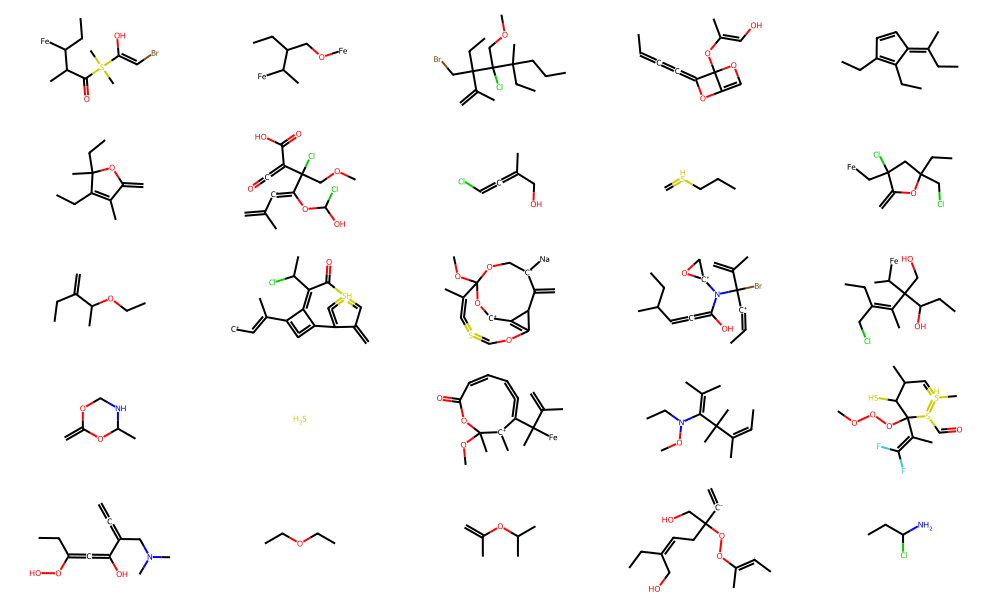

In [14]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))#, legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

(tensor([-0.3825]),)

In [ ]:
#ea.Tags()

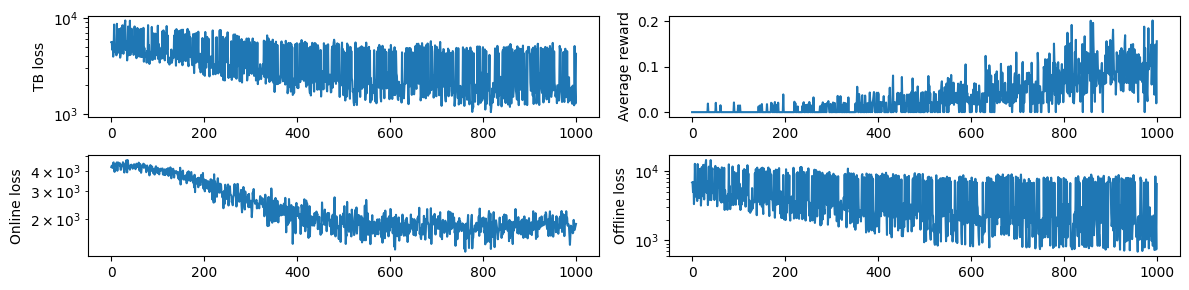

In [15]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(2, 2, figsize=(4*3,3))
ax[0,0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
ax[0,1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[0,1].set_ylabel('Average reward')
#ax[0,2].plot([i.value for i in ea.Scalars('train_logZ')])
#ax[0,2].set_ylabel('Predicted logZ')
ax[1,0].plot([i.value for i in ea.Scalars('train_online_loss')])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
ax[1,1].plot([i.value for i in ea.Scalars('train_offline_loss')])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
#ax[2,0].plot([i.value for i in ea.Scalars('valid_online_loss')])
#ax[2,0].set_yscale('log')
#ax[2,0].set_ylabel('Validation online loss')
#ax[2,1].plot([i.value for i in ea.Scalars('valid_offline_loss')])
#ax[2,1].set_yscale('log')
#ax[2,1].set_ylabel('Validation offline loss')
pp.tight_layout()

$$L = \frac{Z \$$

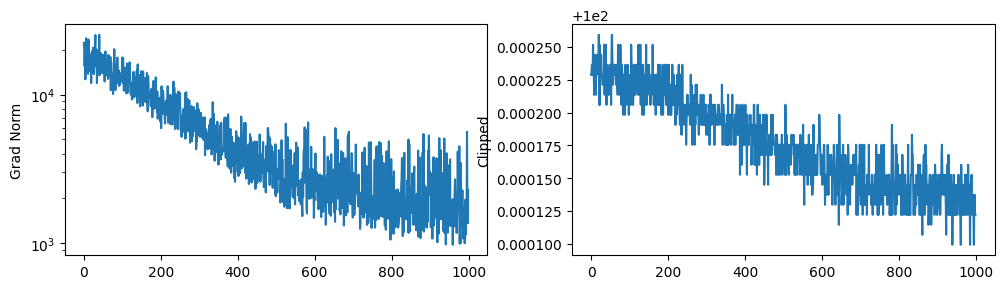

In [16]:
f, ax = pp.subplots(1, 2, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_grad_norm')])
ax[0].set_yscale("log")
ax[0].set_ylabel('Grad Norm')
ax[1].plot([i.value for i in ea.Scalars('train_grad_norm_clip')])
ax[1].set_ylabel('Clipped')
ax

pp.show()

In [18]:
[i.value for i in ea.Scalars('train_grad_norm_clip')]

[100.00022888183594,
 100.00022888183594,
 100.00023651123047,
 100.00023651123047,
 100.00022888183594,
 100.00025177001953,
 100.00022888183594,
 100.00022888183594,
 100.00021362304688,
 100.0002212524414,
 100.00023651123047,
 100.000244140625,
 100.00021362304688,
 100.00022888183594,
 100.00022888183594,
 100.000244140625,
 100.00023651123047,
 100.00023651123047,
 100.000244140625,
 100.00022888183594,
 100.00025939941406,
 100.00020599365234,
 100.00025177001953,
 100.00020599365234,
 100.000244140625,
 100.00022888183594,
 100.000244140625,
 100.00022888183594,
 100.00022888183594,
 100.00022888183594,
 100.0002212524414,
 100.0002212524414,
 100.00022888183594,
 100.00022888183594,
 100.00025177001953,
 100.00021362304688,
 100.00022888183594,
 100.00022888183594,
 100.00025177001953,
 100.00022888183594,
 100.00020599365234,
 100.00023651123047,
 100.00022888183594,
 100.00021362304688,
 100.00022888183594,
 100.00021362304688,
 100.00022888183594,
 100.00022888183594,
 100.

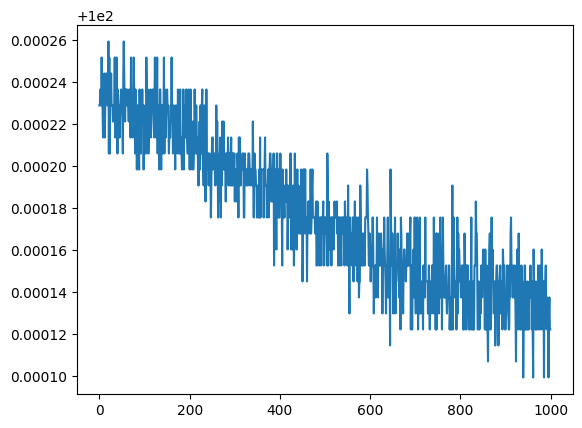

In [ ]:
pp.plot([i.value for i in ea.Scalars('train_grad_norm_clip')])


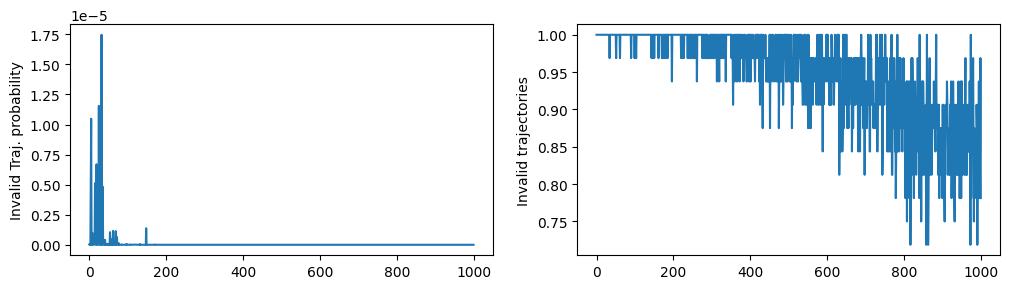

In [19]:
f, ax = pp.subplots(1, 2, figsize=(4*3,3))
ax[0].plot([np.exp(i.value) for i in ea.Scalars('train_invalid_logprob')])

ax[0].set_ylabel('Invalid Traj. probability')
ax[1].plot([i.value for i in ea.Scalars('train_invalid_trajectories')])
ax[1].set_ylabel('Invalid trajectories')

pp.show()

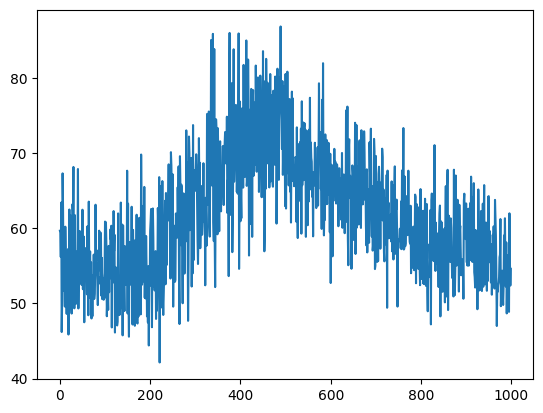

In [20]:

pp.plot([i.value for i in ea.Scalars('train_batch_entropy')])



pp.show()

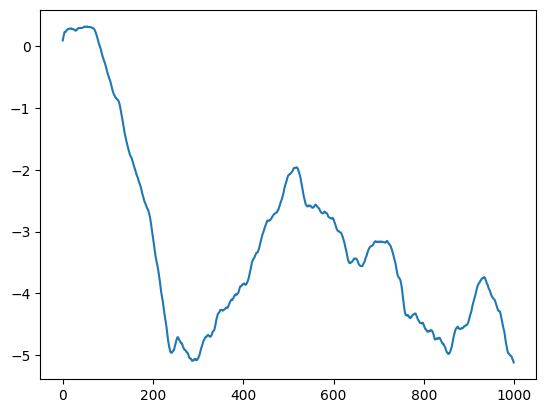

In [21]:

pp.plot([i.value for i in ea.Scalars('train_logZ')])



pp.show()

In [22]:
max([i.value for i in ea.Scalars('train_sampled_reward_avg')])

0.20161890983581543

In [23]:
import sqlite3
import pandas as pd
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [24]:
conn = sqlite3.connect(f"{cfg.log_dir}/train/generated_objs_0.db")

In [25]:
df = pd.read_sql_query("SELECT * FROM results", conn)

In [26]:
import numpy as np

In [29]:
idx_list = sorted([j*128 -i -1  for j in [10,500,700,1000] for i in range(5)])

In [31]:
len(df)

32000

In [30]:
choosendf = df.iloc[idx_list]

IndexError: positional indexers are out-of-bounds

In [ ]:
top_rewards = df.sort_values(by='r', ascending=False).head(25)


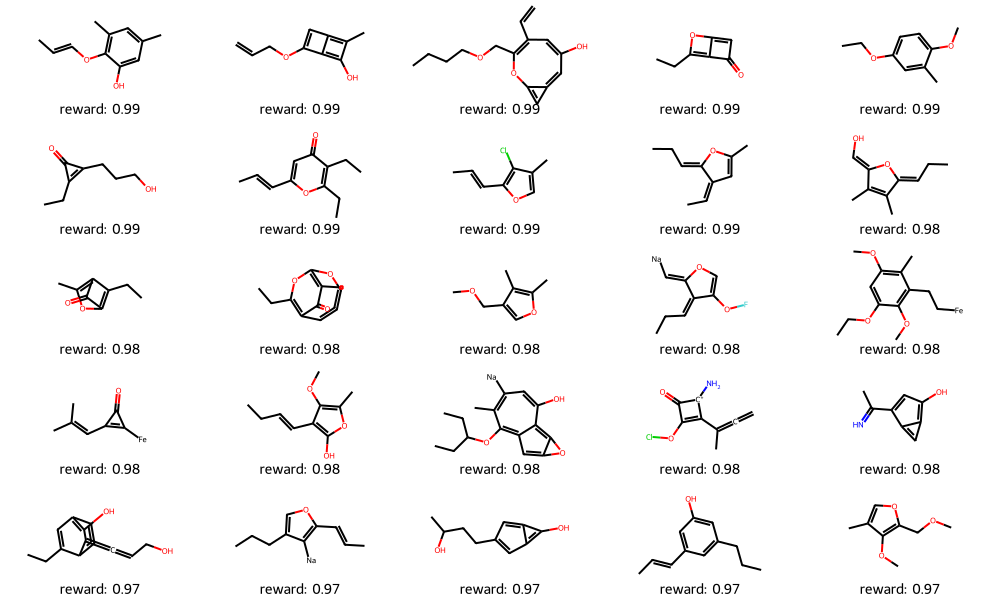

In [ ]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
rewards = top_rewards["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

In [48]:
top_rewards["smi"][:25]

59863                      CC=COc1c(C)cc(C)cc1O
91481                    C=CCOc1cc2c(C)c(O)c1-2
94446                C=Cc1cc(O)cc2cc-2oc1COCCCC
88932                         CCc1oc2cc(=O)c1-2
55695                        CCOc1ccc(OC)c(C)c1
38589                           CCc1c(CCCO)c1=O
93659                  CC=Cc1cc(=O)c(CC)c(CC)o1
70884                          CC=Cc1occ(C)c1Cl
46717                         CC=c1cc(C)oc1=CCC
58558                      CCC=c1oc(=CO)c(C)c1C
48813                         CCc1c2oc(C)c1C2=O
72672                 CCc1oc2c(C)c(=O)c1C=C=CO2
24449                            COCc1coc(C)c1C
64089                     CCC=c1c(OF)coc1=C[Na]
70110              CCOc1cc(OC)c(C)c(CC[Fe])c1OC
21287                      CC(C)=Cc1c([Fe])c1=O
67907                      CCC=Cc1c(O)oc(C)c1OC
73500    CCC(CC)Oc1c2cc3c(c-2c(O)cc([Na])c1C)O3
24721               C=C=C(C)c1c(OCl)c(=O)[c+]1N
28215                      CC(=N)c1cc(O)c2cc1-2
34842               CCc1cc2c(O)c(=C=CCO)

In [ ]:
objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]

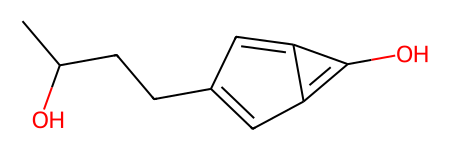

In [39]:
objs[22]

In [40]:
df['iteration'] = df.index // 32

# Compute mean of desired columns per iteration
# Example: mean reward per iteration
# Replace 'reward' with your actual column name
mean_per_iter = df.groupby('iteration')['r'].mean()
mean_per_iter

iteration
0       2.678637e-33
1       2.678637e-33
2       2.678637e-33
3       2.678637e-33
4       2.678637e-33
            ...     
2995    4.116189e-02
2996    1.070143e-01
2997    1.525590e-01
2998    1.671376e-01
2999    1.578867e-01
Name: r, Length: 3000, dtype: float64

In [41]:
import matplotlib.pyplot as plt

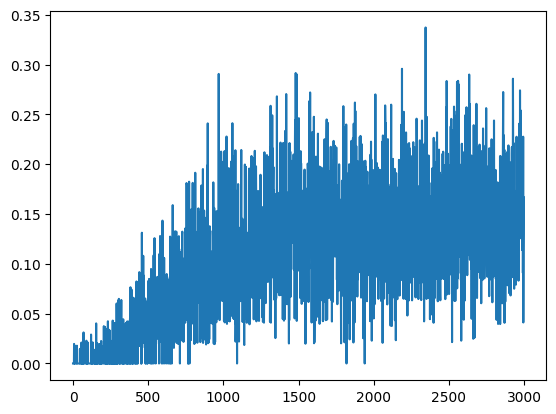

In [42]:
plt.plot(mean_per_iter)

In [43]:
from rdkit import Chem

In [45]:
choosendf

,smi,r,fr_0
315,,2.678637e-33,0.000000
316,,2.678637e-33,0.000000
317,,2.678637e-33,0.000000
318,,2.678637e-33,0.000000
319,,2.678637e-33,0.000000
31995,,2.678637e-33,0.000000
31996,,2.678637e-33,0.000000
31997,,2.678637e-33,0.000000
31998,,2.678637e-33,0.000000
31999,,2.678637e-33,0.000000


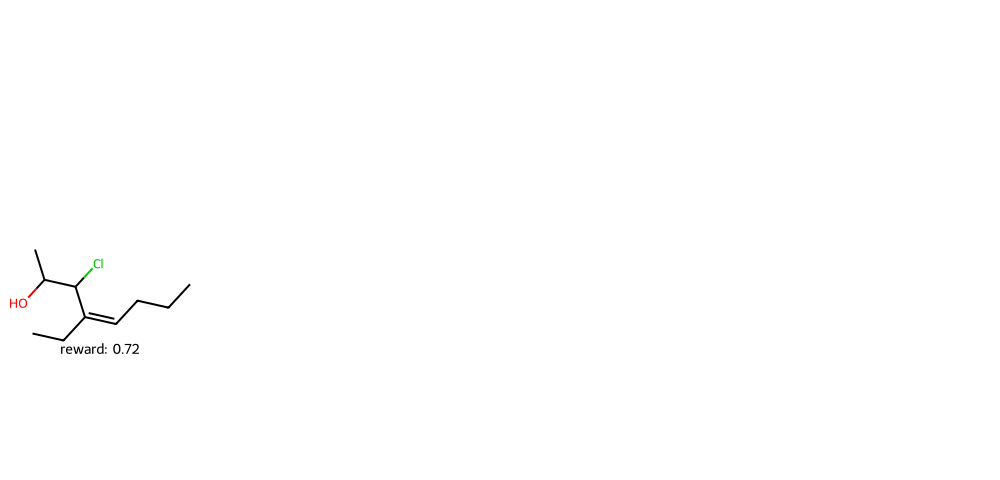

In [44]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in choosendf["smi"]]
rewards = choosendf["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[10], line 23
     18 config.overwrite_existing_exp=True
     22 trial = ScentTrainer(config)
---> 23 trial.run()
     24 save_run(trial)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:271, in GFNTrainer.run(self, logger)
    269 logger.info("Starting training")
    270 start_time = time.time()
--> 271 for it, batch in zip(range(start, 1 + num_training_steps), cycle(train_dl)):
    272     # the memory fragmentation or allocation keeps growing, how often should we clean up?
    273     # is changing the allocation strategy helpful?
    275     if it % 1024 == 0:
    276         gc.collect()

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:377, in cycle(it)
    375 def cycle(it):
    376     while True:
--> 377         for i in it:
    378             yield i

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:708, in _BaseDataLoaderIter.__next__(self)
    705 if self._sampler_iter is None:
    706     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    707     self._reset()  # type: ignore[call-arg]
--> 708 data = self._next_data()
    709 self._num_yielded += 1
    710 if (
    711     self._dataset_kind == _DatasetKind.Iterable
    712     and self._IterableDataset_len_called is not None
    713     and self._num_yielded > self._IterableDataset_len_called
    714 ):

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:764, in _SingleProcessDataLoaderIter._next_data(self)
    762 def _next_data(self):
    763     index = self._next_index()  # may raise StopIteration
--> 764     data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    765     if self._pin_memory:
    766         data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\_utils\fetch.py:42, in _IterableDatasetFetcher.fetch(self, possibly_batched_index)
     40         raise StopIteration
     41 else:
---> 42     data = next(self.dataset_iter)
     43 return self.collate_fn(data)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:80, in DataSource.__iter__(self)
     78 for d in batch_infos:
     79     batch_info.update(d)
---> 80 yield self.create_batch(trajs, batch_info)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:220, in DataSource.create_batch(self, trajs, batch_info)
    218 ci = torch.stack([t["cond_info"]["encoding"] for t in trajs])
    219 log_rewards = torch.stack([t["log_reward"] for t in trajs])
--> 220 batch = self.algo.construct_batch(trajs, ci, log_rewards)
    221 batch.num_online = sum(t.get("is_online", 0) for t in trajs)
    222 batch.num_offline = len(trajs) - batch.num_online

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in TrajectoryBalance.construct_batch(self, trajs, cond_info, log_rewards)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in <listcomp>(.0)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\envs\mol_building_env.py:280, in MolBuildingEnvContext.graph_to_Data(self, g)
    277     remove_node_mask[i] = 1
    278 for k, sl in zip(self.atom_attrs, self.atom_attr_slice):
    279     # idx > 0 means that the attribute is not the default value
--> 280     idx = self.atom_attr_values[k].index(ad[k]) if k in ad else 0
    281     x[i, sl + idx] = 1
    282     if k == "v":

ValueError: 1 is not in list

In [1]:
# Utils
import warnings
import os

# Plotting
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt
import seaborn as sns

# File management
import json
import numpy as np
import pandas as pd


# GFlowNET
import gflownet
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.config import init_empty, Config

# OpenPOM
from pom_models.functions import fragance_propabilities_from_smiles_test, fragance_propabilities_from_smiles_train

# Others
from tensorboard.backend.event_processing import event_accumulator
import torch
from rdkit import Chem

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
# Model class must be defined somewhere
state = torch.load(os.path.join("./logs/mcf_mask_invalid_rewards_5/", "model_final_save.pt"), weights_only=False)
#model = statemodel.eval()
#state["models_state_dict"]
config = state["cfg"]
env_ctx = state["env_ctx"]

In [5]:
model = gflownet.models.graph_transformer.GraphTransformerGFN(state["env_ctx"],state["cfg"])
model.load_state_dict(state["models_state_dict"][0])
model.eval()

GraphTransformerGFN(
  (transf): GraphTransformer(
    (x2h): Sequential(
      (0): Linear(in_features=29, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (e2h): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (c2h): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (graph2emb): ModuleList(
      (0):

In [6]:
algo = TrajectoryBalance(GraphBuildingEnv(),state["env_ctx"],state["cfg"])

In [8]:
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [9]:
ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=1,
            max_nodes=20,
        )

In [11]:
# Generate molecules
trajs = algo.create_training_data_from_own_samples(model, 1000)
objs = [ctx.graph_to_obj(i['result']) for i in trajs]


In [50]:


config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/mcf_mask_invalid_rewards_5"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 
config.validate_every=1000
config.algo.valid_num_from_policy= 32
config.algo.valid_num_from_dataset= 32
config.num_training_steps = 3000 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True

config.algo.tb.mask_invalid_rewards = False

task = ScentTask(OpenPOMDataset(train=True), config)

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [51]:
obj_props, is_valid = task.compute_obj_properties(objs)
cond_info = task.sample_conditional_information(len(obj_props), 1)
log_rewards = task.cond_info_to_logreward(cond_info, obj_props)



tensor([[0.7532],
        [0.6291],
        [0.7186],
        [0.7781],
        [0.5895],
        [0.7485],
        [0.6287],
        [0.6484],
        [0.7138],
        [0.7903],
        [0.6854],
        [0.6485],
        [0.6742],
        [0.7786],
        [0.6996],
        [0.6585],
        [0.6938],
        [0.6100],
        [0.6515],
        [0.6944],
        [0.9035],
        [0.6400],
        [0.6800],
        [0.5834],
        [0.8154],
        [0.7496],
        [0.8268],
        [0.7075],
        [0.7026],
        [0.7158],
        [0.6745],
        [0.6493],
        [0.6514],
        [0.8071],
        [0.7024],
        [0.7858],
        [0.7786],
        [0.6207],
        [0.6476],
        [0.6915],
        [0.6672],
        [0.6661],
        [0.6007],
        [0.7291],
        [0.6748],
        [0.7546],
        [0.7060],
        [0.7376],
        [0.6897],
        [0.5702],
        [0.7493],
        [0.6795],
        [0.6442],
        [0.7091],
        [0.6363],
        [0

In [53]:
log_rewards

tensor([-0.2834, -0.4635, -0.3305, -0.2509, -0.5285, -0.2896, -0.4641, -0.4333,
        -0.3371, -0.2353, -0.3778, -0.4331, -0.3942, -0.2502, -0.3572, -0.4178,
        -0.3656, -0.4943, -0.4285, -0.3647, -0.1015, -0.4463, -0.3856, -0.5390,
        -0.2041, -0.2883, -0.1902, -0.3460, -0.3529, -0.3344, -0.3938, -0.4318,
        -0.4286, -0.2143, -0.3533, -0.2410, -0.2503, -0.4770, -0.4345, -0.3690,
        -0.4047, -0.4063, -0.5096, -0.3160, -0.3933, -0.2816, -0.3481, -0.3044,
        -0.3715, -0.5617, -0.2886, -0.3863, -0.4398, -0.3437, -0.4522, -0.1867,
        -0.4567, -0.2903, -0.5708, -0.4016, -0.4202, -0.3090, -0.3070, -0.3025,
        -0.1678, -0.3855, -0.0116, -0.4676, -0.3112, -0.4197, -0.3975, -0.1671,
        -0.4675, -0.3470, -0.4970, -0.4551, -0.4320, -0.3222, -0.2894, -0.4344,
        -0.3063, -0.3039, -0.3270, -0.4293, -0.3024, -0.2283, -0.3973, -0.2753,
        -0.4064, -0.4030, -0.2491, -0.3760, -0.4226, -0.2805, -0.3988, -0.3954,
        -0.4624, -0.4539, -0.5524, -0.33

In [54]:
len(objs),len(obj_props),len(is_valid),len(log_rewards)

(1000, 202, 1000, 202)

202

In [55]:
valid_indices = np.where(is_valid)[0]

In [63]:
expanded_log_rewards = np.float64(np.full(1000, -75))
expanded_log_rewards[valid_indices] = log_rewards
len(expanded_log_rewards)

1000

In [64]:
expanded_obj_props = np.full(1000, np.exp(-75))
expanded_obj_props[valid_indices] = obj_props.flatten()
len(expanded_obj_props)

1000

In [65]:
sample_df = pd.DataFrame(
    dict(
        smiles=[Chem.MolToSmiles(o) for o in objs],
        obj_props=expanded_obj_props,
        is_valid=is_valid,
        log_rewards=expanded_log_rewards
        )
)

In [66]:
sample_df.head(10)

,smiles,obj_props,is_valid,log_rewards
0,COC1(OO)C=C=C2C=C(OC3OC(C)C=C=C31)C2=O,2.678637e-33,False,-75.000000
1,C=C1CC1C(Br)CCCC,2.678637e-33,False,-75.000000
2,CCC(C)=C=C(C=O)CBr,7.532007e-01,True,-0.283424
3,CCCC1CC=C2C=C(C2)C1=O,2.678637e-33,False,-75.000000
4,CC=CCC(=C=C1OC(C)(O)OC1=C=C=CCC)CBr,2.678637e-33,False,-75.000000
5,CCC1=CC(CC)(OC)OC1(CC)CCCO,2.678637e-33,False,-75.000000
6,CC=C1CCC=C(C(C)C)OC1,2.678637e-33,False,-75.000000
7,CC1=CC=C1C=O,2.678637e-33,False,-75.000000
8,OC1=C=CCC=CC1=C[C-](O)O,2.678637e-33,False,-75.000000
9,CC1C=COC(O)=C2C3=C(CCOC2=C1OC(=O)O)O3,2.678637e-33,False,-75.000000


In [67]:
sample_df[sample_df["is_valid"]==True]

,smiles,obj_props,is_valid,log_rewards
2,CCC(C)=C=C(C=O)CBr,0.753201,True,-0.283424
14,C=C(CCC)OCC,0.629109,True,-0.463451
15,CC=CCOCCCC,0.718552,True,-0.330517
17,C=CCCC(=C=C=O)C(=C=C=O)OC,0.778113,True,-0.250883
26,CC=CC(CC)CCC,0.589491,True,-0.528495
...,...,...,...,...
962,CC=COCC(CC)CO,0.688438,True,-0.373330
964,C=CC(O)=C(CC)OC=C(C)CC,0.807112,True,-0.214293
980,CCCC(=C=CCO)CC,0.648061,True,-0.433771
990,C=CC(O)(CC)OC,0.656031,True,-0.421548


In [68]:
sample_df["log_rewards"]

0     -75.000000
1     -75.000000
2      -0.283424
3     -75.000000
4     -75.000000
         ...    
995   -75.000000
996   -75.000000
997   -75.000000
998   -75.000000
999    -0.177764
Name: log_rewards, Length: 1000, dtype: float64

In [69]:
sample_df.to_csv("sample_experiment_copy.csv", index=False)